In [109]:
import numpy as np
import matplotlib.pyplot as plt
import json
import skimage.measure

In [86]:

import copy

child_last   = "└─── "
child_middle = "├─── "
space_pre    = "     "
middle_pre   = "│    "
def build_tree(obj, key='#', level=0, level_info = {}):
    if(level > 0):
        for i in range(level-1):
            if(level_info[i] == 'last'):
                print(space_pre, end="")
            else:
                print(middle_pre, end="")
        if(level_info[level-1] == 'last'):
            child_pre = child_last
        else:
            child_pre = child_middle
        print(child_pre, end="")
    
    if(key != '#'):
        print(key, end=": ")
    print(type(obj), end=" ")
    if(type(obj) is list):
        print("[{}]".format(len(obj)))
    else:
        print()
    if(type(obj) is dict):
        key_arr = list(obj.keys())
        for idx in range(len(key_arr)):
            li = copy.deepcopy(level_info)
            if(idx == len(key_arr)-1):
                li[level] = 'last'
            else:
                li[level] = 'middle'
            
            key = key_arr[idx]
            build_tree(obj[key], key=key, level = level + 1, level_info = li)
    elif(type(obj) is list):
        li = copy.deepcopy(level_info)
        li[level] = 'last'
        build_tree(obj[0], key='#', level = level + 1, level_info = li)

In [120]:
def plotface(datapoint):
    xrr = []
    yrr = []

    for keypoint in datapoint['face']:
        xrr.append(keypoint[0])
        yrr.append(keypoint[1])

    xrr = np.array(xrr)
    yrr = np.array(yrr)

    plt.scatter(xrr, yrr, s = 10)
    plt.xlim([xrr.min(), xrr.max()])
    plt.ylim([yrr.min(), yrr.max()])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')

In [111]:
def getSecondFromTimeStamp(timestamp):
    return timestamp["hour"]*60*60 + timestamp["minute"]*60 + timestamp["seconds"]

In [124]:
def gaze__processOneSession(gaze_arr, latest = None):
    xrr = []
    yrr = []
    if(latest != None):
        endtime = getSecondFromTimeStamp(gaze_arr[-1]["timestamp"])
    for gaze in gaze_arr:
        if(latest != None):
            curr_time = getSecondFromTimeStamp(gaze["timestamp"])
            if(endtime - curr_time > latest):
                continue
        xrr.append(gaze["gaze"]["x"])
        yrr.append(gaze["gaze"]["y"])
    return np.array(xrr), np.array(yrr)

In [113]:
path_root = "/home/arnab/MEGAsync/Eye Tracking/Data_Backup/saved_sessions_september_24/"

In [114]:
session_name = "session_2021-09-24T10:10:40.966059/session_2021-09-24T10:10:40.966059.json"
with open(path_root + session_name, 'r') as f:
    session = json.load(f)

In [115]:
build_tree(session)

<class 'dict'> 
└─── hdehheeafrlqlylodn58si: <class 'list'> [241]
     └─── <class 'dict'> 
          ├─── gaze: <class 'dict'> 
          │    ├─── x: <class 'float'> 
          │    └─── y: <class 'float'> 
          ├─── gazefeatures: <class 'dict'> 
          │    ├─── gaze: <class 'list'> [2]
          │    │    └─── <class 'int'> 
          │    └─── screen: <class 'list'> [2]
          │         └─── <class 'int'> 
          ├─── face: <class 'list'> [468]
          │    └─── <class 'list'> [3]
          │         └─── <class 'int'> 
          └─── timestamp: <class 'dict'> 
               ├─── hour: <class 'int'> 
               ├─── minute: <class 'int'> 
               ├─── seconds: <class 'int'> 
               └─── milliseconds: <class 'int'> 


In [116]:
datapoint = None
for id in session:
    print(id)
    for dp in session[id]:
        datapoint = dp
        break

hdehheeafrlqlylodn58si


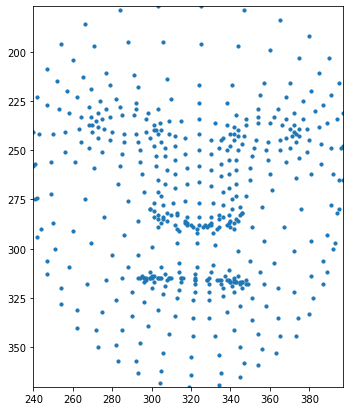

In [121]:
scle = 7
plt.rcParams["figure.figsize"] = (scle*16/9,scle)
plotface(datapoint)

In [125]:
xrr, yrr = gaze__processOneSession(session['hdehheeafrlqlylodn58si'], 10)
xrr.shape, yrr.shape



((124,), (124,))

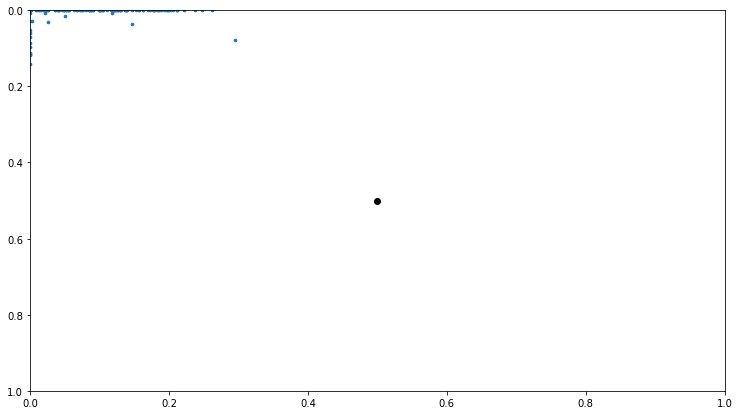

In [126]:
scle = 7
plt.rcParams["figure.figsize"] = (scle*16/9,scle)
plt.scatter(xrr, yrr, s=scle)
plt.xlim([0,1])
plt.ylim([0,1])
plt.gca().invert_yaxis()
plt.scatter(.5,.5, color='k')

In [97]:
marker_track = {
    "Position 1":   [.5, .5],
    "Position 2":   [.1, .1],	
    "Position 3":   [.1, .8],	
    "Position 4":	[.8, .8],	
    "Position 5":	[.8, .1],	
}

In [98]:
with open("session_track.json", 'r') as f:
    session_track = json.load(f)

In [99]:
def loadjson_singleSession(session_name):
    folder = session_name.split('.json')[0]
    with open(path_root + folder + "/" + session_name, 'r') as f:
        session = json.load(f)
        if(len(session.keys()) != 1):
            print("this session has {} ids".format(len(session.keys())))
        for id in session:
            return session[id]

In [102]:
def plotHeatmap(xrr, yrr, subplot):
    heat_map = np.zeros((1001, 1001))
    for idx in range(xrr.shape[0]):
        xx = int(round(xrr[idx]*1000))
        yy = int(round(yrr[idx]*1000))
        heat_map[yy, xx] += 1
    print("heatmap shape", heat_map.shape)
    heatmap_reduced = skimage.measure.block_reduce(heat_map, (100,100), np.mean)
    print(heatmap_reduced.shape, heatmap_reduced.min(), heatmap_reduced.max())
    subplot.pcolormesh(np.arange(11), np.arange(11), heatmap_reduced, 
                    shading='gouraud', 
                    vmin=heatmap_reduced.min(), 
                    vmax=heatmap_reduced.max())
    subplot.invert_yaxis()


In [106]:
def calculate_MSE(xrr, yrr, marker_x, marker_y):
    ret = 0
    for idx in range(xrr.shape[0]):
        ret += (marker_x - xrr[idx])**2 + (marker_y - yrr[idx])**2
    return ret/xrr.shape[0]

Position 1
(184,) (184,)
(147,) (147,)
heatmap shape (1001, 1001)
(11, 11) 0.0 0.0025
heatmap shape (1001, 1001)
(11, 11) 0.0 0.0016
>>>>>>>>> ON >>>>>>>>>> mse = 0.10485364673913047
>>>>>>>>> OFF >>>>>>>>> mse = 0.05226411564625852
------------------------------------------------------------------------------------------------------------------
Position 2
(185,) (185,)
(148,) (148,)
heatmap shape (1001, 1001)
(11, 11) 0.0 0.0075
heatmap shape (1001, 1001)
(11, 11) 0.0 0.0019
>>>>>>>>> ON >>>>>>>>>> mse = 0.03987109729729731
>>>>>>>>> OFF >>>>>>>>> mse = 0.16678372972972974
------------------------------------------------------------------------------------------------------------------
Position 3
(121,) (121,)
(231,) (231,)
heatmap shape (1001, 1001)
(11, 11) 0.0 0.0046
heatmap shape (1001, 1001)
(11, 11) 0.0 0.0026
>>>>>>>>> ON >>>>>>>>>> mse = 0.3824463884297521
>>>>>>>>> OFF >>>>>>>>> mse = 0.0904112467532468
-------------------------------------------------------------------------

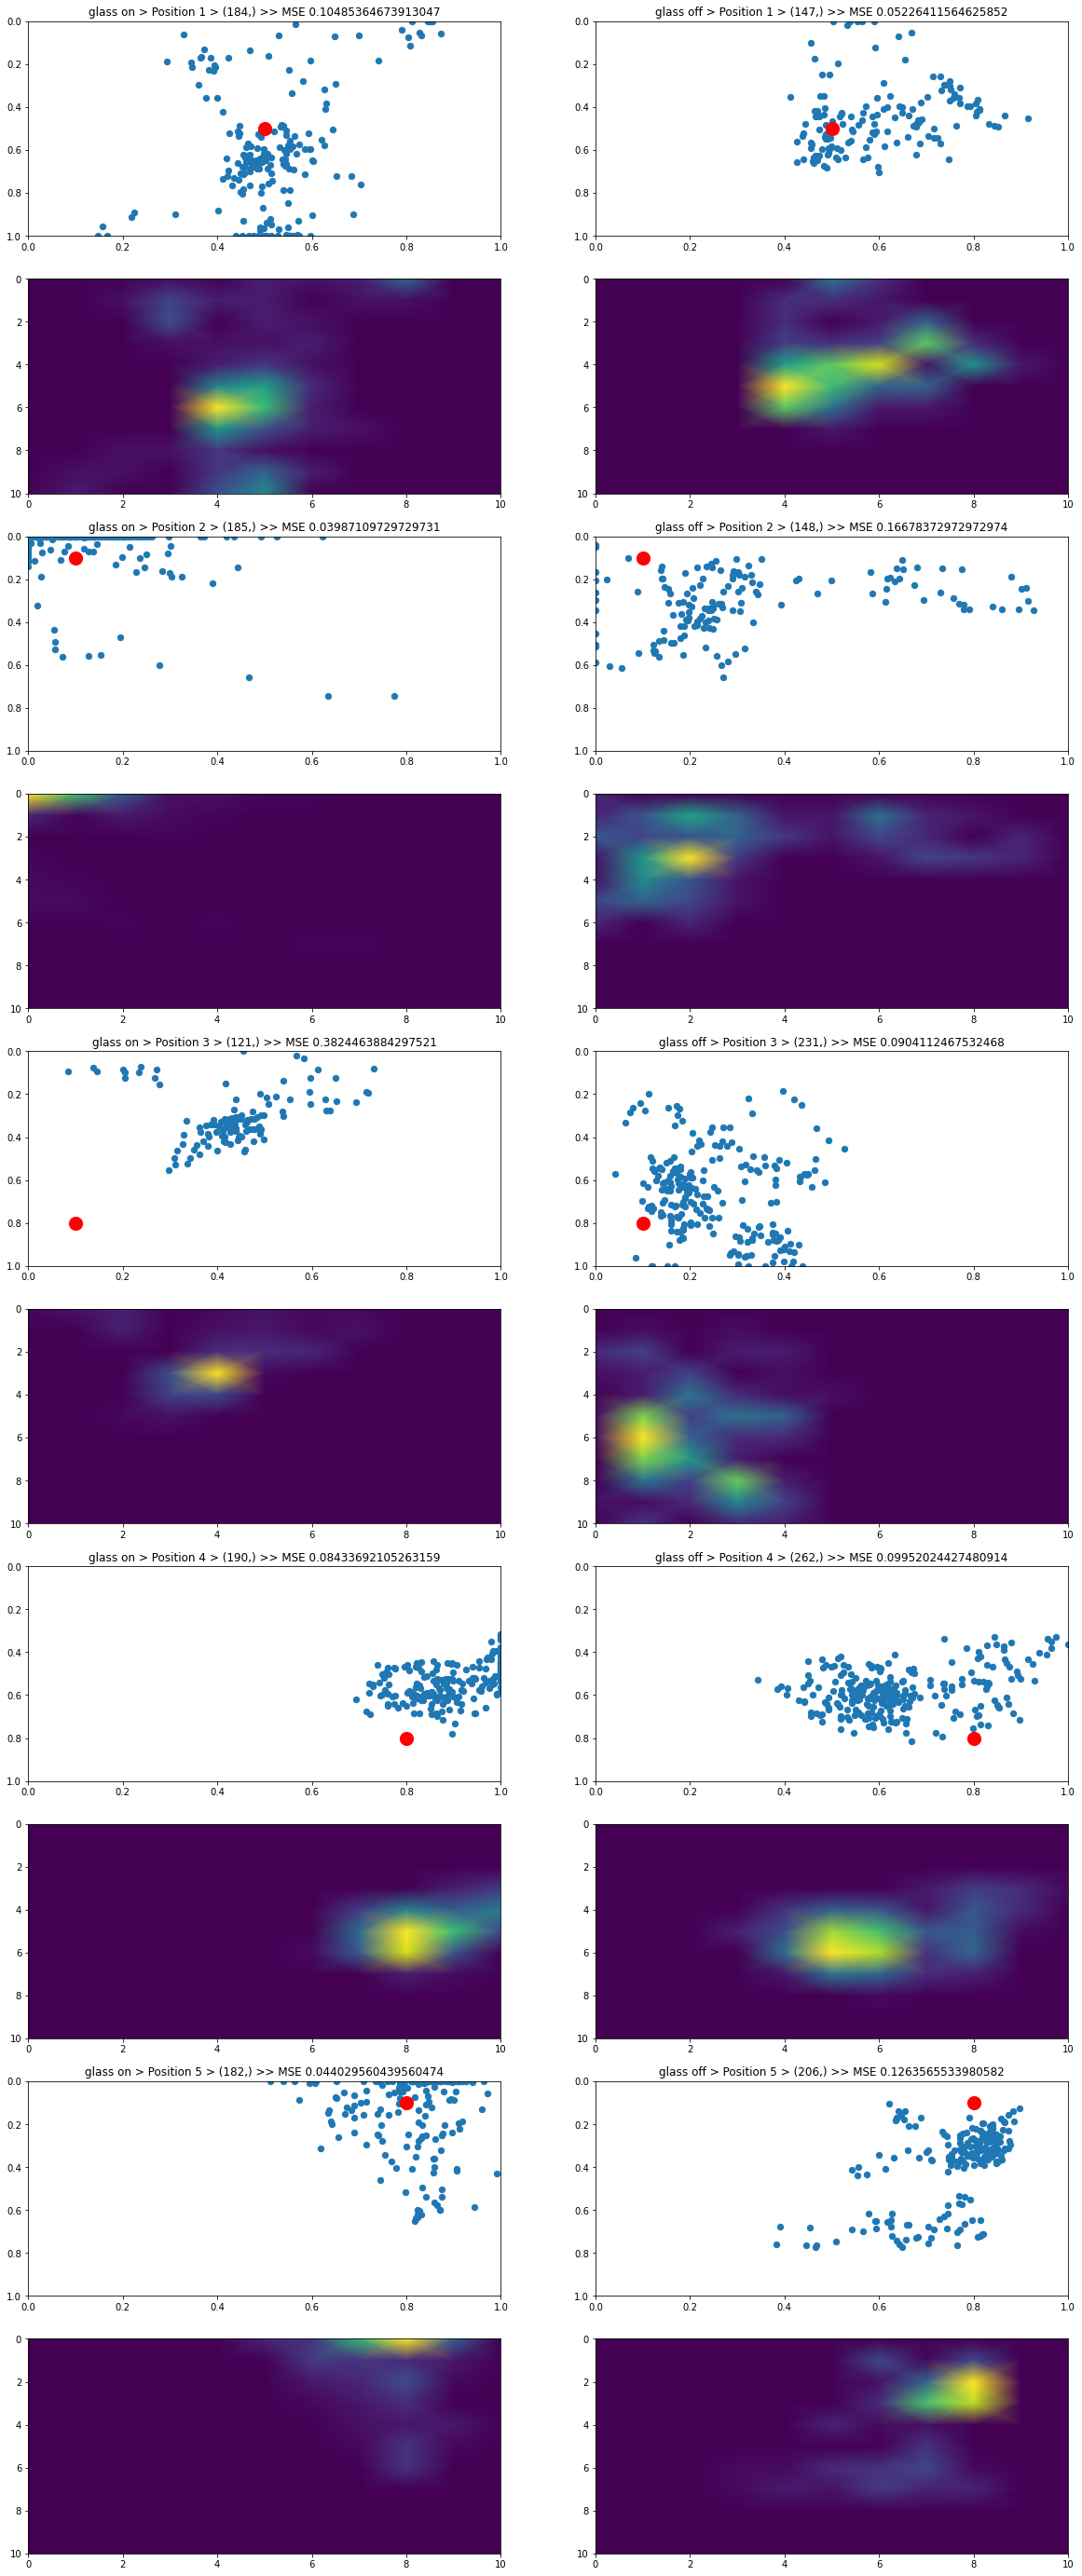

In [129]:
###################################################################################
num_person = 2
num_keys = 5
time_limit = 15
###################################################################################

col_fix = num_person
col_width = 20
plt.rcParams["figure.figsize"] = (col_width, (num_keys*col_width)/col_fix)
fig, ax = plt.subplots(nrows=num_keys*2, ncols=col_fix)


for i in range(1, 6):
    key = "Position {}".format(i)
    glass_on = loadjson_singleSession(session_track['P1'][key])
    glass_off = loadjson_singleSession(session_track['P1_without_glasses'][key])

    on_xrr, on_yrr = gaze__processOneSession(glass_on, time_limit)
    on_mse = calculate_MSE(on_xrr, on_yrr, marker_track[key][0], marker_track[key][1])
    
    off_xrr, off_yrr = gaze__processOneSession(glass_off, time_limit)
    off_mse = calculate_MSE(off_xrr, off_yrr, marker_track[key][0], marker_track[key][1])

    print(key)
    print(on_xrr.shape, on_yrr.shape)
    print(off_xrr.shape, off_yrr.shape)

    scle = 40
    sb_plot = ax[2*(i-1), 0]
    sb_plot.scatter(on_xrr, on_yrr, s=scle)
    sb_plot.set_xlim([0,1])
    sb_plot.set_ylim([0,1])
    sb_plot.invert_yaxis()
    sb_plot.scatter(marker_track[key][0], marker_track[key][1], color='red', s=scle*5)
    sb_plot.title.set_text("glass on > {} > {} >> MSE {}".format(key, on_xrr.shape, on_mse))

    sb_plot = ax[2*(i-1), 1]
    sb_plot.scatter(off_xrr, off_yrr, s=scle)
    sb_plot.set_xlim([0,1])
    sb_plot.set_ylim([0,1])
    sb_plot.invert_yaxis()
    sb_plot.scatter(marker_track[key][0], marker_track[key][1], color='red', s=scle*5)
    sb_plot.title.set_text("glass off > {} > {} >> MSE {}".format(key, off_xrr.shape, off_mse))

    plotHeatmap(on_xrr, on_yrr, ax[2*(i-1) + 1, 0])
    plotHeatmap(off_xrr, off_yrr, ax[2*(i-1) + 1, 1])

    print(">>>>>>>>> ON >>>>>>>>>> mse = {}".format(on_mse))
    print(">>>>>>>>> OFF >>>>>>>>> mse = {}".format(off_mse))
    print("------------------------------------------------------------------------------------------------------------------")